# Nowotarski的手法
- LightGBMで trend 予測
- LSTMで residual 予測（短期変動）
- 最終価格 = trend_pred + seasonal（固定） + residual_pred

In [204]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import optuna
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import STL
from scipy.optimize import minimize_scalar, minimize

import pickle
import random
import importlib
import sys
import joblib

import shap
import matplotlib.pyplot as plt
import japanize_matplotlib

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Attention, Multiply, Lambda, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Concatenate

from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf

In [205]:
import common

# モジュールの再読み込み
importlib.reload(common)

_common = common.Common()
_common.BASE_PATH

PosixPath('/Users/iwasakitakahiro/github')

In [206]:
common_func_path = _common.COMMON_FUNC_PATH
sys.path.append(str(common_func_path))

import func

importlib.reload(func)

<module 'func' from '/Users/iwasakitakahiro/github/共通関数/func.py'>

In [207]:
train_df = pd.read_csv('../output/中間データ/学習用データ/train_preprocessed.csv')

In [208]:
train_df[_common.UNIQUE_KEY_COLS] = pd.to_datetime(train_df[_common.UNIQUE_KEY_COLS])
train_df = train_df.sort_values(_common.UNIQUE_KEY_COLS).set_index(_common.UNIQUE_KEY_COLS)

price_series = train_df[_common.TARGET_COL].resample('D').mean()

## STL分解

In [209]:
# STL分解（1ヶ月周期）
stl_result1 = STL(price_series, period=30).fit()
train_df['trend'] = stl_result1.trend

# モデル1用に日単位で集約（例：日平均）
model1_df = train_df.resample('D').mean().reset_index()
model2_df = train_df.copy().reset_index()

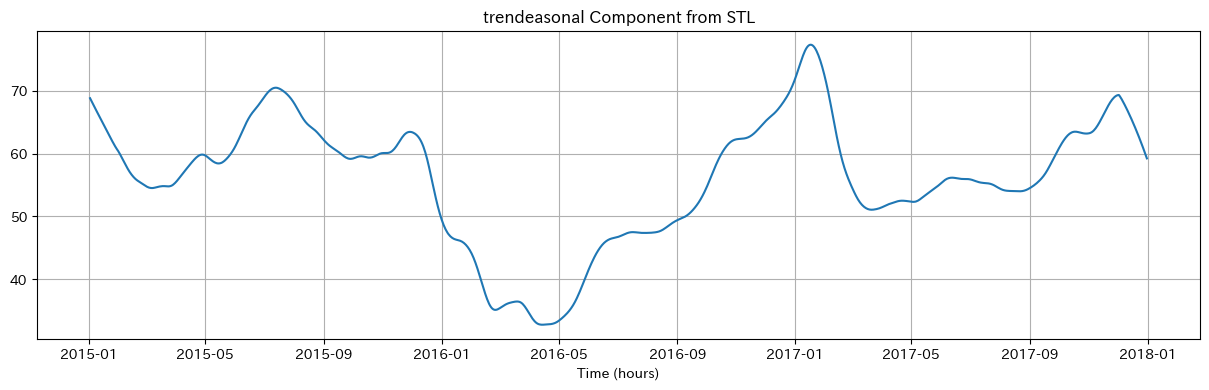

In [210]:
import matplotlib.pyplot as plt
trend = stl_result1.trend

plt.figure(figsize=(15,4))
plt.plot(trend[:100000])  # 最初の1000時間分だけ表示
plt.title("trendeasonal Component from STL")
plt.xlabel("Time (hours)")
plt.grid()
plt.show()

## 前日市場：Trend(LightGBM)

#### 特徴量追加

In [211]:
model1_df.columns

Index(['time', 'generation_biomass', 'generation_fossil_gas',
       'generation_fossil_hard_coal', 'generation_fossil_oil',
       'generation_hydro_run_of_river_and_poundage',
       'generation_hydro_water_reservoir', 'generation_nuclear',
       'generation_other_renewable', 'generation_solar',
       'generation_wind_onshore', 'total_load_actual', 'price_actual',
       'gene_sum', 'gene_load_ratio', 'residual_demand', 'high_cost_ratio',
       'hour', 'weekday', 'month', 'quarter', 'gene_sum_exp_mean_to_t',
       'gene_sum_exp_std_to_t', 'gene_sum_scaled',
       'total_load_actual_exp_mean_to_t', 'total_load_actual_exp_std_to_t',
       'total_load_actual_scaled', 'weighted_wind_speed', 'weighted_temp',
       'weighted_pressure', 'weighted_dew_point', 'weighted_clouds_all',
       'trend'],
      dtype='object')

In [212]:
fe_model1 = [
    # 'time',
    'generation_biomass', 'generation_fossil_gas',
    'generation_fossil_hard_coal', 'generation_fossil_oil',
    'generation_hydro_run_of_river_and_poundage',
    'generation_hydro_water_reservoir', 'generation_nuclear',
    'generation_other_renewable', 'generation_solar',
    'generation_wind_onshore',
    'total_load_actual',
    # 'price_actual',
    'gene_sum', 'gene_load_ratio', 'residual_demand', 'high_cost_ratio',
    'hour', 'weekday', 'month', 'quarter', 
    'gene_sum_exp_mean_to_t', # 'gene_sum_exp_std_to_t', 'gene_sum_scaled',
    'total_load_actual_exp_mean_to_t', # 'total_load_actual_exp_std_to_t', 'total_load_actual_scaled', 
    'weighted_wind_speed', 'weighted_temp','weighted_pressure', 'weighted_dew_point', 'weighted_clouds_all',
    # 'trend'
]

In [213]:
model1_df = model1_df[model1_df['trend'].notnull()]
X_train = model1_df[fe_model1]
y_train = model1_df['trend']

In [214]:
# 再現性確保のための固定シード
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)

# Optunaのシードも固定
sampler = optuna.samplers.TPESampler(seed=SEED)

# LightGBMにも同様に
default_params = {
    'objective': 'quantile',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'random_state': SEED,
    'verbosity': -1
}

tscv = TimeSeriesSplit(n_splits=5)

#### ハイパーパラメータチューニング

In [215]:
# 最適化の対象関数
def objective(trial):
    return func.run_optuna(
        trial=trial,
        features=X_train,         # 特徴量データフレーム
        target=y_train,           # 目的変数
        cv_strategy=tscv,         # ← partition_col → cv_strategy に変更済み
        model_name='lgb',
        default_columns=default_params,
        metric='rmse',
        random_seed=SEED
    )

# Optuna スタディの作成・実行
study = optuna.create_study(
    direction='minimize',
    sampler=optuna.samplers.TPESampler(seed=SEED)
)
study.optimize(objective, n_trials=100)

# 最良トライアルの結果
trial = study.best_trial
lgb_params = default_params | trial.params

# 結果の表示
print('Best trial:')
print(f'RMSE: {trial.value:.4f}')
print('Params:')
for key, value in trial.params.items():
    print(f'{key}: {value}')

[I 2025-06-17 10:38:45,721] A new study created in memory with name: no-name-9aa35e83-430f-4f55-85c1-de466054ce66

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
The reported value is ignored because this `step` 0 is already reported.
The reported value is ignored because this `step` 1 is already reported.
The reported value is ignored because this `step` 2 is already reported.
The reported value is ignored because this `step` 3 is already reported.
The reported value is ignored because this `step` 4 is already reported.
The reported value is ignored because this `step` 5 is already reported.
The reported value is ignored because this `step` 6 

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 4.80424
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 25.2809
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[775]	valid_0's rmse: 8.05525
Training until validation scores don't improve for 30 rounds


Found `num_iterations` in params. Will use it instead of argument
The reported value is ignored because this `step` 0 is already reported.
The reported value is ignored because this `step` 1 is already reported.
The reported value is ignored because this `step` 2 is already reported.
The reported value is ignored because this `step` 3 is already reported.
The reported value is ignored because this `step` 4 is already reported.
The reported value is ignored because this `step` 5 is already reported.
The reported value is ignored because this `step` 6 is already reported.
The reported value is ignored because this `step` 7 is already reported.
The reported value is ignored because this `step` 8 is already reported.
The reported value is ignored because this `step` 9 is already reported.
The reported value is ignored because this `step` 10 is already reported.
The reported value is ignored because this `step` 11 is already reported.
The reported value is ignored because this `step` 12 is 

Did not meet early stopping. Best iteration is:
[801]	valid_0's rmse: 6.3689
Training until validation scores don't improve for 30 rounds


The reported value is ignored because this `step` 291 is already reported.
The reported value is ignored because this `step` 292 is already reported.
The reported value is ignored because this `step` 293 is already reported.
The reported value is ignored because this `step` 294 is already reported.
The reported value is ignored because this `step` 295 is already reported.
The reported value is ignored because this `step` 296 is already reported.
The reported value is ignored because this `step` 297 is already reported.
The reported value is ignored because this `step` 298 is already reported.
The reported value is ignored because this `step` 299 is already reported.
The reported value is ignored because this `step` 300 is already reported.
The reported value is ignored because this `step` 301 is already reported.
The reported value is ignored because this `step` 302 is already reported.
The reported value is ignored because this `step` 303 is already reported.
The reported value is ign

Did not meet early stopping. Best iteration is:
[798]	valid_0's rmse: 2.25716
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 4.74875
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[5]	valid_0's rmse: 24.5251
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 10.0436
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 9.67223
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[5]	valid_0's rmse: 2.27622
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 4.67412
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[2]	valid_0's rmse: 23.9692
Training until validation scores don't improve for 30 

The reported value is ignored because this `step` 51 is already reported.
The reported value is ignored because this `step` 52 is already reported.
The reported value is ignored because this `step` 53 is already reported.
The reported value is ignored because this `step` 54 is already reported.
The reported value is ignored because this `step` 55 is already reported.
The reported value is ignored because this `step` 56 is already reported.
The reported value is ignored because this `step` 57 is already reported.
The reported value is ignored because this `step` 58 is already reported.
The reported value is ignored because this `step` 59 is already reported.
The reported value is ignored because this `step` 60 is already reported.
The reported value is ignored because this `step` 61 is already reported.
The reported value is ignored because this `step` 62 is already reported.
Found `num_iterations` in params. Will use it instead of argument
The reported value is ignored because this `st

Early stopping, best iteration is:
[220]	valid_0's rmse: 6.11382
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[123]	valid_0's rmse: 2.14307
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 4.62063
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 23.9706
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[5]	valid_0's rmse: 8.64181
Training until validation scores don't improve for 30 rounds



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
The reported value is ignored because this `step` 0 is already reported.
The reported value is ignored because this `step` 1 is already reported.
The reported value is ignored because this `step` 2 is already reported.
The reported value is ignored because this `step` 3 is already reported.
The reported value is ignored because this `step` 4 is already reported.
The reported value is ignored because this `step` 5 is already reported.
The reported value is ignored because this `step` 6 is already reported.
The reported value is ignored because this `step` 7 is already reported.
The reported value i

Early stopping, best iteration is:
[155]	valid_0's rmse: 5.51381
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[13]	valid_0's rmse: 2.22353
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 5.14703
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[14]	valid_0's rmse: 25.1632
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 10.4629
Training until validation scores don't improve for 30 rounds


The reported value is ignored because this `step` 20 is already reported.
The reported value is ignored because this `step` 21 is already reported.
The reported value is ignored because this `step` 22 is already reported.
The reported value is ignored because this `step` 23 is already reported.
The reported value is ignored because this `step` 24 is already reported.
The reported value is ignored because this `step` 25 is already reported.
The reported value is ignored because this `step` 26 is already reported.
The reported value is ignored because this `step` 27 is already reported.
The reported value is ignored because this `step` 28 is already reported.
The reported value is ignored because this `step` 29 is already reported.
The reported value is ignored because this `step` 30 is already reported.
Found `num_iterations` in params. Will use it instead of argument
The reported value is ignored because this `step` 0 is already reported.
The reported value is ignored because this `ste

Early stopping, best iteration is:
[198]	valid_0's rmse: 9.19839
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[14]	valid_0's rmse: 3.06226
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 4.57948
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[64]	valid_0's rmse: 24.5002
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 9.17034
Training until validation scores don't improve for 30 rounds



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
The reported value is ignored because this `step` 0 is already reported.
The reported value is ignored because this `step` 1 is already reported.
The reported value is ignored because this `step` 2 is already reported.
The reported value is ignored because this `step` 3 is already reported.
The reported value is ignored because this `step` 4 is already reported.
The reported value is ignored because this `step` 5 is already reported.
The reported value is ignored because this `step` 6 is already reported.
The reported value is ignored because this `step` 7 is already reported.
The reported value i

Did not meet early stopping. Best iteration is:
[632]	valid_0's rmse: 7.56301
Training until validation scores don't improve for 30 rounds


Found `num_iterations` in params. Will use it instead of argument
The reported value is ignored because this `step` 0 is already reported.
The reported value is ignored because this `step` 1 is already reported.
The reported value is ignored because this `step` 2 is already reported.
The reported value is ignored because this `step` 3 is already reported.
The reported value is ignored because this `step` 4 is already reported.
The reported value is ignored because this `step` 5 is already reported.
The reported value is ignored because this `step` 6 is already reported.
The reported value is ignored because this `step` 7 is already reported.
The reported value is ignored because this `step` 8 is already reported.
The reported value is ignored because this `step` 9 is already reported.
The reported value is ignored because this `step` 10 is already reported.
The reported value is ignored because this `step` 11 is already reported.
The reported value is ignored because this `step` 12 is 

Did not meet early stopping. Best iteration is:
[635]	valid_0's rmse: 2.4565
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 4.58634
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 24.6306
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 9.23014
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 9.26238
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[107]	valid_0's rmse: 4.73418
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 4.66763
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 24.7516
Training until validation scores don't improve for 30


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
The reported value is ignored because this `step` 0 is already reported.
The reported value is ignored because this `step` 1 is already reported.
The reported value is ignored because this `step` 2 is already reported.
The reported value is ignored because this `step` 3 is already reported.
The reported value is ignored because this `step` 4 is already reported.
The reported value is ignored because this `step` 5 is already reported.
The reported value is ignored because this `step` 6 is already reported.
The reported value is ignored because this `step` 7 is already reported.
The reported value i

Early stopping, best iteration is:
[46]	valid_0's rmse: 7.75628
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[71]	valid_0's rmse: 6.4665
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[60]	valid_0's rmse: 2.20629
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 4.62204
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 24.2339
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 8.92107
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[18]	valid_0's rmse: 8.77293
Training until validation scores don't improve for 30 rounds


The reported value is ignored because this `step` 19 is already reported.
The reported value is ignored because this `step` 20 is already reported.
The reported value is ignored because this `step` 21 is already reported.
The reported value is ignored because this `step` 22 is already reported.
The reported value is ignored because this `step` 23 is already reported.
The reported value is ignored because this `step` 24 is already reported.
The reported value is ignored because this `step` 25 is already reported.
The reported value is ignored because this `step` 26 is already reported.
The reported value is ignored because this `step` 27 is already reported.
The reported value is ignored because this `step` 28 is already reported.
The reported value is ignored because this `step` 29 is already reported.
The reported value is ignored because this `step` 30 is already reported.
Found `num_iterations` in params. Will use it instead of argument
The reported value is ignored because this `st

Early stopping, best iteration is:
[434]	valid_0's rmse: 2.19951
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 4.64379
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 24.7436
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 9.53015
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[34]	valid_0's rmse: 7.59894
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[66]	valid_0's rmse: 2.42325



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Found `num_iterations` in params. Will use it instead of argument
[I 2025-06-17 10:38:49,295] Trial 18 pruned. Trial was pruned at iteration 0.

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
The reported value is ignored because this `step` 0 is already reported.
The reported value is ignored because this `step` 1 is already reported.
The reported value is ignored because this `step` 

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[4]	valid_0's rmse: 4.57919
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 24.3036
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 9.04021
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 9.07769
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[66]	valid_0's rmse: 2.28665



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Found `num_iterations` in params. Will use it instead of argument
[I 2025-06-17 10:38:49,519] Trial 22 pruned. Trial was pruned at iteration 0.

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
The reported value is ignored because this `step` 0 is already reported.
The reported value is ignored because this `step` 1 is already reported.
The reported value is ignored because this `step` 

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 4.59883
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[28]	valid_0's rmse: 24.4598
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[48]	valid_0's rmse: 8.54813
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[148]	valid_0's rmse: 6.0204
Training until validation scores don't improve for 30 rounds


The reported value is ignored because this `step` 35 is already reported.
The reported value is ignored because this `step` 36 is already reported.
The reported value is ignored because this `step` 37 is already reported.
The reported value is ignored because this `step` 38 is already reported.
The reported value is ignored because this `step` 39 is already reported.
The reported value is ignored because this `step` 40 is already reported.
The reported value is ignored because this `step` 41 is already reported.
The reported value is ignored because this `step` 42 is already reported.
The reported value is ignored because this `step` 43 is already reported.
The reported value is ignored because this `step` 44 is already reported.
The reported value is ignored because this `step` 45 is already reported.
The reported value is ignored because this `step` 46 is already reported.
The reported value is ignored because this `step` 47 is already reported.
The reported value is ignored because 

Early stopping, best iteration is:
[58]	valid_0's rmse: 2.15905
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 4.59813
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[14]	valid_0's rmse: 24.5604
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 9.33207
Training until validation scores don't improve for 30 rounds


Found `num_iterations` in params. Will use it instead of argument
The reported value is ignored because this `step` 0 is already reported.
The reported value is ignored because this `step` 1 is already reported.
The reported value is ignored because this `step` 2 is already reported.
The reported value is ignored because this `step` 3 is already reported.
The reported value is ignored because this `step` 4 is already reported.
The reported value is ignored because this `step` 5 is already reported.
The reported value is ignored because this `step` 6 is already reported.
The reported value is ignored because this `step` 7 is already reported.
The reported value is ignored because this `step` 8 is already reported.
The reported value is ignored because this `step` 9 is already reported.
The reported value is ignored because this `step` 10 is already reported.
The reported value is ignored because this `step` 11 is already reported.
The reported value is ignored because this `step` 12 is 

Did not meet early stopping. Best iteration is:
[367]	valid_0's rmse: 5.96665
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[130]	valid_0's rmse: 2.07237
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[114]	valid_0's rmse: 4.57537
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 24.4156
Training until validation scores don't improve for 30 rounds



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
The reported value is ignored because this `step` 0 is already reported.
The reported value is ignored because this `step` 1 is already reported.
The reported value is ignored because this `step` 2 is already reported.
The reported value is ignored because this `step` 3 is already reported.
The reported value is ignored because this `step` 4 is already reported.
The reported value is ignored because this `step` 5 is already reported.
The reported value is ignored because this `step` 6 is already reported.
The reported value is ignored because this `step` 7 is already reported.
The reported value i

Early stopping, best iteration is:
[1]	valid_0's rmse: 9.05973
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[2]	valid_0's rmse: 9.06456
Training until validation scores don't improve for 30 rounds


[I 2025-06-17 10:38:50,482] Trial 25 finished with value: 9.955861062620157 and parameters: {'learning_rate': 0.0035579181866746594, 'max_depth': 7, 'num_leaves': 97, 'min_data_in_leaf': 64, 'num_iterations': 232, 'bagging_fraction': 0.6412131875773934, 'bagging_freq': 2, 'alpha': 0.700762771495217}. Best is trial 3 with value: 8.994070792213517.

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
The reported value is ignored because this `step` 0 is already reported.
The reported value is ignored because this `step` 1 is already reported.
The reported value is ignored because this `step` 2 is already reported.
The reported value is ignored becaus

Did not meet early stopping. Best iteration is:
[232]	valid_0's rmse: 2.66403
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 4.57937
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[8]	valid_0's rmse: 24.2387
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[41]	valid_0's rmse: 8.61969
Training until validation scores don't improve for 30 rounds


The reported value is ignored because this `step` 56 is already reported.
The reported value is ignored because this `step` 57 is already reported.
The reported value is ignored because this `step` 58 is already reported.
The reported value is ignored because this `step` 59 is already reported.
The reported value is ignored because this `step` 60 is already reported.
The reported value is ignored because this `step` 61 is already reported.
The reported value is ignored because this `step` 62 is already reported.
The reported value is ignored because this `step` 63 is already reported.
The reported value is ignored because this `step` 64 is already reported.
The reported value is ignored because this `step` 65 is already reported.
The reported value is ignored because this `step` 66 is already reported.
The reported value is ignored because this `step` 67 is already reported.
The reported value is ignored because this `step` 68 is already reported.
The reported value is ignored because 

Early stopping, best iteration is:
[271]	valid_0's rmse: 5.98802
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[104]	valid_0's rmse: 2.29441
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 4.58101
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[8]	valid_0's rmse: 23.8173
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[14]	valid_0's rmse: 8.41258
Training until validation scores don't improve for 30 rounds



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
The reported value is ignored because this `step` 0 is already reported.
The reported value is ignored because this `step` 1 is already reported.
The reported value is ignored because this `step` 2 is already reported.
The reported value is ignored because this `step` 3 is already reported.
The reported value is ignored because this `step` 4 is already reported.
The reported value is ignored because this `step` 5 is already reported.
The reported value is ignored because this `step` 6 is already reported.
The reported value is ignored because this `step` 7 is already reported.
The reported value i

Early stopping, best iteration is:
[80]	valid_0's rmse: 6.25011
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[41]	valid_0's rmse: 1.88233
Training until validation scores don't improve for 30 rounds



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
The reported value is ignored because this `step` 0 is already reported.
The reported value is ignored because this `step` 1 is already reported.
The reported value is ignored because this `step` 2 is already reported.
The reported value is ignored because this `step` 3 is already reported.
The reported value is ignored because this `step` 4 is already reported.
The reported value is ignored because this `step` 5 is already reported.
The reported value is ignored because this `step` 6 is already reported.
The reported value is ignored because this `step` 7 is already reported.
The reported value i

Early stopping, best iteration is:
[1]	valid_0's rmse: 4.58805
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[8]	valid_0's rmse: 23.6523
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[5]	valid_0's rmse: 8.71596
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[28]	valid_0's rmse: 5.889
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[19]	valid_0's rmse: 2.36561
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 4.5802
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[6]	valid_0's rmse: 24.3523
Training until validation scores don't improve for 30 rounds



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
The reported value is ignored because this `step` 0 is already reported.
The reported value is ignored because this `step` 1 is already reported.
The reported value is ignored because this `step` 2 is already reported.
The reported value is ignored because this `step` 3 is already reported.
The reported value is ignored because this `step` 4 is already reported.
The reported value is ignored because this `step` 5 is already reported.
The reported value is ignored because this `step` 6 is already reported.
The reported value is ignored because this `step` 7 is already reported.
The reported value i

Early stopping, best iteration is:
[5]	valid_0's rmse: 8.85284
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[6]	valid_0's rmse: 7.09348
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[7]	valid_0's rmse: 2.17588
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 4.5815
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[27]	valid_0's rmse: 23.428
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[2]	valid_0's rmse: 8.25327
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[29]	valid_0's rmse: 6.26915
Training until validation scores don't improve for 30 rounds


The reported value is ignored because this `step` 13 is already reported.
The reported value is ignored because this `step` 14 is already reported.
The reported value is ignored because this `step` 15 is already reported.
The reported value is ignored because this `step` 16 is already reported.
The reported value is ignored because this `step` 17 is already reported.
The reported value is ignored because this `step` 18 is already reported.
The reported value is ignored because this `step` 19 is already reported.
The reported value is ignored because this `step` 20 is already reported.
The reported value is ignored because this `step` 21 is already reported.
The reported value is ignored because this `step` 22 is already reported.
The reported value is ignored because this `step` 23 is already reported.
The reported value is ignored because this `step` 24 is already reported.
The reported value is ignored because this `step` 25 is already reported.
The reported value is ignored because 

Early stopping, best iteration is:
[25]	valid_0's rmse: 1.94396
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 4.58236
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[90]	valid_0's rmse: 24.3735
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[100]	valid_0's rmse: 8.71451
Training until validation scores don't improve for 30 rounds


The reported value is ignored because this `step` 112 is already reported.
The reported value is ignored because this `step` 113 is already reported.
The reported value is ignored because this `step` 114 is already reported.
The reported value is ignored because this `step` 115 is already reported.
The reported value is ignored because this `step` 116 is already reported.
The reported value is ignored because this `step` 117 is already reported.
The reported value is ignored because this `step` 118 is already reported.
The reported value is ignored because this `step` 119 is already reported.
The reported value is ignored because this `step` 120 is already reported.
The reported value is ignored because this `step` 121 is already reported.
The reported value is ignored because this `step` 122 is already reported.
The reported value is ignored because this `step` 123 is already reported.
The reported value is ignored because this `step` 124 is already reported.
The reported value is ign

Did not meet early stopping. Best iteration is:
[660]	valid_0's rmse: 6.74684
Training until validation scores don't improve for 30 rounds


Found `num_iterations` in params. Will use it instead of argument
The reported value is ignored because this `step` 0 is already reported.
The reported value is ignored because this `step` 1 is already reported.
The reported value is ignored because this `step` 2 is already reported.
The reported value is ignored because this `step` 3 is already reported.
The reported value is ignored because this `step` 4 is already reported.
The reported value is ignored because this `step` 5 is already reported.
The reported value is ignored because this `step` 6 is already reported.
The reported value is ignored because this `step` 7 is already reported.
The reported value is ignored because this `step` 8 is already reported.
The reported value is ignored because this `step` 9 is already reported.
The reported value is ignored because this `step` 10 is already reported.
The reported value is ignored because this `step` 11 is already reported.
The reported value is ignored because this `step` 12 is 

Did not meet early stopping. Best iteration is:
[659]	valid_0's rmse: 2.4308
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 4.59252
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[8]	valid_0's rmse: 23.4024
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[2]	valid_0's rmse: 7.98276
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[18]	valid_0's rmse: 6.4306
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[16]	valid_0's rmse: 2.53711



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Found `num_iterations` in params. Will use it instead of argument
[I 2025-06-17 10:38:52,717] Trial 42 pruned. Trial was pruned at iteration 0.

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Found `num_iterations` in params. Will use it instead of argument
[I 2025-06-17 10:38:52,737] Trial 43 pruned. Trial was pruned at iteration 0.

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 4.57912
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 24.5356
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 9.15364
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 9.19321
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 5.213
Training until validation scores don't improve for 30 rounds


Found `num_iterations` in params. Will use it instead of argument
The reported value is ignored because this `step` 0 is already reported.
The reported value is ignored because this `step` 1 is already reported.
The reported value is ignored because this `step` 2 is already reported.
The reported value is ignored because this `step` 3 is already reported.
The reported value is ignored because this `step` 4 is already reported.
The reported value is ignored because this `step` 5 is already reported.
The reported value is ignored because this `step` 6 is already reported.
The reported value is ignored because this `step` 7 is already reported.
The reported value is ignored because this `step` 8 is already reported.
The reported value is ignored because this `step` 9 is already reported.
The reported value is ignored because this `step` 10 is already reported.
The reported value is ignored because this `step` 11 is already reported.
The reported value is ignored because this `step` 12 is 

Early stopping, best iteration is:
[1]	valid_0's rmse: 4.58682
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[8]	valid_0's rmse: 23.8653
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[6]	valid_0's rmse: 8.48753
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[144]	valid_0's rmse: 5.56229
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[16]	valid_0's rmse: 2.60608



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Found `num_iterations` in params. Will use it instead of argument
[I 2025-06-17 10:38:53,195] Trial 52 pruned. Trial was pruned at iteration 0.

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
The reported value is ignored because this `step` 0 is already reported.
The reported value is ignored because this `step` 1 is already reported.
The reported value is ignored because this `step` 

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 4.5793
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[8]	valid_0's rmse: 23.1087
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[2]	valid_0's rmse: 8.95576
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[10]	valid_0's rmse: 6.66694
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[11]	valid_0's rmse: 2.14637
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 4.58722
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[10]	valid_0's rmse: 24.2035
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[9]	valid_0's rmse: 8.76934
Traini

Found `num_iterations` in params. Will use it instead of argument
The reported value is ignored because this `step` 0 is already reported.
The reported value is ignored because this `step` 1 is already reported.
The reported value is ignored because this `step` 2 is already reported.
The reported value is ignored because this `step` 3 is already reported.
The reported value is ignored because this `step` 4 is already reported.
The reported value is ignored because this `step` 5 is already reported.
The reported value is ignored because this `step` 6 is already reported.
The reported value is ignored because this `step` 7 is already reported.
The reported value is ignored because this `step` 8 is already reported.
The reported value is ignored because this `step` 9 is already reported.
The reported value is ignored because this `step` 10 is already reported.
The reported value is ignored because this `step` 11 is already reported.
The reported value is ignored because this `step` 12 is 

Early stopping, best iteration is:
[20]	valid_0's rmse: 5.96256
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[18]	valid_0's rmse: 2.39519
Training until validation scores don't improve for 30 rounds



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Found `num_iterations` in params. Will use it instead of argument
[I 2025-06-17 10:38:53,621] Trial 62 pruned. Trial was pruned at iteration 1.

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
The reported value is ignored because this `step` 0 is already reported.
The reported value is ignored because this `step` 1 is already reported.
The reported value is ignored because this `step` 

Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 4.57931
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 24.5583
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[7]	valid_0's rmse: 8.51123
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[78]	valid_0's rmse: 6.18196
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[11]	valid_0's rmse: 2.16365



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Found `num_iterations` in params. Will use it instead of argument
[I 2025-06-17 10:38:53,840] Trial 65 pruned. Trial was pruned at iteration 0.

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
The reported value is ignored because this `step` 0 is already reported.
The reported value is ignored because this `step` 1 is already reported.
The reported value is ignored because this `step` 

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 4.58594
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[4]	valid_0's rmse: 24.1675
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[8]	valid_0's rmse: 8.7873
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[108]	valid_0's rmse: 5.77005
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[20]	valid_0's rmse: 2.2326



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Found `num_iterations` in params. Will use it instead of argument
[I 2025-06-17 10:38:54,081] Trial 68 pruned. Trial was pruned at iteration 0.

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Found `num_iterations` in params. Will use it instead of argument
[I 2025-06-17 10:38:54,104] Trial 69 pruned. Trial was pruned at iteration 0.

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 4.5793
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[8]	valid_0's rmse: 23.2415
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[2]	valid_0's rmse: 8.82575
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[9]	valid_0's rmse: 6.42676
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[14]	valid_0's rmse: 2.12296
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 4.57929
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[5]	valid_0's rmse: 23.3807
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[5]	valid_0's rmse: 9.13481
Training

The reported value is ignored because this `step` 1 is already reported.
The reported value is ignored because this `step` 2 is already reported.
The reported value is ignored because this `step` 3 is already reported.
The reported value is ignored because this `step` 4 is already reported.
The reported value is ignored because this `step` 5 is already reported.
The reported value is ignored because this `step` 6 is already reported.
The reported value is ignored because this `step` 7 is already reported.
The reported value is ignored because this `step` 8 is already reported.
The reported value is ignored because this `step` 9 is already reported.
The reported value is ignored because this `step` 10 is already reported.
The reported value is ignored because this `step` 11 is already reported.
The reported value is ignored because this `step` 12 is already reported.
The reported value is ignored because this `step` 13 is already reported.
The reported value is ignored because this `ste

Early stopping, best iteration is:
[36]	valid_0's rmse: 6.06435
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[11]	valid_0's rmse: 2.08566
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 4.58392
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 24.1788
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[4]	valid_0's rmse: 8.64777
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[62]	valid_0's rmse: 5.75395
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[8]	valid_0's rmse: 1.96686



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Found `num_iterations` in params. Will use it instead of argument
[I 2025-06-17 10:38:54,584] Trial 75 pruned. Trial was pruned at iteration 0.

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Found `num_iterations` in params. Will use it instead of argument
[I 2025-06-17 10:38:54,606] Trial 76 pruned. Trial was pruned at iteration 0.

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 4.58081
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[12]	valid_0's rmse: 23.0328
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[4]	valid_0's rmse: 8.39421
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[12]	valid_0's rmse: 6.58808
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[39]	valid_0's rmse: 2.02631
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 4.58104
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 24.4363
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[5]	valid_0's rmse: 7.75922
Train

The reported value is ignored because this `step` 33 is already reported.
The reported value is ignored because this `step` 34 is already reported.
The reported value is ignored because this `step` 35 is already reported.
The reported value is ignored because this `step` 36 is already reported.
The reported value is ignored because this `step` 37 is already reported.
The reported value is ignored because this `step` 38 is already reported.
The reported value is ignored because this `step` 39 is already reported.
The reported value is ignored because this `step` 40 is already reported.
The reported value is ignored because this `step` 41 is already reported.
The reported value is ignored because this `step` 42 is already reported.
[I 2025-06-17 10:38:54,853] Trial 79 finished with value: 9.175549288857558 and parameters: {'learning_rate': 0.12152729413884888, 'max_depth': 8, 'num_leaves': 111, 'min_data_in_leaf': 81, 'num_iterations': 524, 'bagging_fraction': 0.35647699310990966, 'baggi

Early stopping, best iteration is:
[14]	valid_0's rmse: 2.10871
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 4.58092
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[16]	valid_0's rmse: 24.1597
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[17]	valid_0's rmse: 8.53701
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[47]	valid_0's rmse: 6.07545
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[39]	valid_0's rmse: 2.00507
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 4.5793
Training until validation scores don't improve for 30 rounds


The reported value is ignored because this `step` 6 is already reported.
The reported value is ignored because this `step` 7 is already reported.
The reported value is ignored because this `step` 8 is already reported.
The reported value is ignored because this `step` 9 is already reported.
The reported value is ignored because this `step` 10 is already reported.
The reported value is ignored because this `step` 11 is already reported.
The reported value is ignored because this `step` 12 is already reported.
The reported value is ignored because this `step` 13 is already reported.
The reported value is ignored because this `step` 14 is already reported.
The reported value is ignored because this `step` 15 is already reported.
The reported value is ignored because this `step` 16 is already reported.
The reported value is ignored because this `step` 17 is already reported.
The reported value is ignored because this `step` 18 is already reported.
The reported value is ignored because this

Early stopping, best iteration is:
[12]	valid_0's rmse: 23.9514
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[6]	valid_0's rmse: 8.93511
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[188]	valid_0's rmse: 5.26245
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[9]	valid_0's rmse: 2.79629



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Found `num_iterations` in params. Will use it instead of argument
[I 2025-06-17 10:38:55,281] Trial 84 pruned. Trial was pruned at iteration 0.

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Found `num_iterations` in params. Will use it instead of argument
[I 2025-06-17 10:38:55,303] Trial 85 pruned. Trial was pruned at iteration 0.

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 4.5807
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[8]	valid_0's rmse: 23.5526
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[11]	valid_0's rmse: 8.53809
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[24]	valid_0's rmse: 6.30055
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[28]	valid_0's rmse: 2.17549
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 4.58044
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[8]	valid_0's rmse: 23.6339
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[5]	valid_0's rmse: 8.35629


Found `num_iterations` in params. Will use it instead of argument
The reported value is ignored because this `step` 0 is already reported.
The reported value is ignored because this `step` 1 is already reported.
The reported value is ignored because this `step` 2 is already reported.
The reported value is ignored because this `step` 3 is already reported.
The reported value is ignored because this `step` 4 is already reported.
The reported value is ignored because this `step` 5 is already reported.
The reported value is ignored because this `step` 6 is already reported.
The reported value is ignored because this `step` 7 is already reported.
The reported value is ignored because this `step` 8 is already reported.
The reported value is ignored because this `step` 9 is already reported.
The reported value is ignored because this `step` 10 is already reported.
The reported value is ignored because this `step` 11 is already reported.
The reported value is ignored because this `step` 12 is 

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[16]	valid_0's rmse: 6.49748
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[28]	valid_0's rmse: 1.9527
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 4.58256
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[52]	valid_0's rmse: 23.3668
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[14]	valid_0's rmse: 8.13261
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[21]	valid_0's rmse: 6.40309


The reported value is ignored because this `step` 50 is already reported.
Found `num_iterations` in params. Will use it instead of argument
The reported value is ignored because this `step` 0 is already reported.
The reported value is ignored because this `step` 1 is already reported.
The reported value is ignored because this `step` 2 is already reported.
The reported value is ignored because this `step` 3 is already reported.
The reported value is ignored because this `step` 4 is already reported.
The reported value is ignored because this `step` 5 is already reported.
The reported value is ignored because this `step` 6 is already reported.
The reported value is ignored because this `step` 7 is already reported.
The reported value is ignored because this `step` 8 is already reported.
The reported value is ignored because this `step` 9 is already reported.
The reported value is ignored because this `step` 10 is already reported.
The reported value is ignored because this `step` 11 is 

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[35]	valid_0's rmse: 1.99239
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 4.58062
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[10]	valid_0's rmse: 23.8328
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[15]	valid_0's rmse: 8.25421
Training until validation scores don't improve for 30 rounds


Found `num_iterations` in params. Will use it instead of argument
The reported value is ignored because this `step` 0 is already reported.
The reported value is ignored because this `step` 1 is already reported.
The reported value is ignored because this `step` 2 is already reported.
The reported value is ignored because this `step` 3 is already reported.
The reported value is ignored because this `step` 4 is already reported.
The reported value is ignored because this `step` 5 is already reported.
The reported value is ignored because this `step` 6 is already reported.
The reported value is ignored because this `step` 7 is already reported.
The reported value is ignored because this `step` 8 is already reported.
The reported value is ignored because this `step` 9 is already reported.
The reported value is ignored because this `step` 10 is already reported.
The reported value is ignored because this `step` 11 is already reported.
The reported value is ignored because this `step` 12 is 

Early stopping, best iteration is:
[105]	valid_0's rmse: 6.02272
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[56]	valid_0's rmse: 2.12003
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 4.57931
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[6]	valid_0's rmse: 24.0477
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[12]	valid_0's rmse: 8.66435
Training until validation scores don't improve for 30 rounds


Found `num_iterations` in params. Will use it instead of argument
The reported value is ignored because this `step` 0 is already reported.
The reported value is ignored because this `step` 1 is already reported.
The reported value is ignored because this `step` 2 is already reported.
The reported value is ignored because this `step` 3 is already reported.
The reported value is ignored because this `step` 4 is already reported.
The reported value is ignored because this `step` 5 is already reported.
The reported value is ignored because this `step` 6 is already reported.
The reported value is ignored because this `step` 7 is already reported.
The reported value is ignored because this `step` 8 is already reported.
The reported value is ignored because this `step` 9 is already reported.
The reported value is ignored because this `step` 10 is already reported.
The reported value is ignored because this `step` 11 is already reported.
The reported value is ignored because this `step` 12 is 

Early stopping, best iteration is:
[79]	valid_0's rmse: 6.06078
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[35]	valid_0's rmse: 2.30421
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 4.57911
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[59]	valid_0's rmse: 23.6189
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[20]	valid_0's rmse: 8.04299
Training until validation scores don't improve for 30 rounds


The reported value is ignored because this `step` 18 is already reported.
The reported value is ignored because this `step` 19 is already reported.
The reported value is ignored because this `step` 20 is already reported.
The reported value is ignored because this `step` 21 is already reported.
The reported value is ignored because this `step` 22 is already reported.
The reported value is ignored because this `step` 23 is already reported.
The reported value is ignored because this `step` 24 is already reported.
The reported value is ignored because this `step` 25 is already reported.
The reported value is ignored because this `step` 26 is already reported.
The reported value is ignored because this `step` 27 is already reported.
The reported value is ignored because this `step` 28 is already reported.
The reported value is ignored because this `step` 29 is already reported.
The reported value is ignored because this `step` 30 is already reported.
The reported value is ignored because 

Early stopping, best iteration is:
[70]	valid_0's rmse: 6.40206
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[64]	valid_0's rmse: 2.18369
Best trial:
RMSE: 8.9245
Params:
learning_rate: 0.12271576135859637
max_depth: 8
num_leaves: 112
min_data_in_leaf: 81
num_iterations: 523
bagging_fraction: 0.47064285457867117
bagging_freq: 6
alpha: 0.7033346771012601


#### 全データで学習

In [216]:
# LightGBM Dataset の作成
lgb_train = lgb.Dataset(X_train, label=y_train)

callbacks = [
    lgb.log_evaluation(period=50)
]

# モデルの再学習（最終学習）
trend_model = lgb.train(
    lgb_params,
    train_set=lgb_train,
    callbacks=callbacks,
)

# トレーニングデータで予測
y_train_pred = trend_model.predict(X_train)

# RMSEを計算
final_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

print(f"LightGBMのトレーニングRMSE: {final_rmse:.4f}")

Found `num_iterations` in params. Will use it instead of argument


LightGBMのトレーニングRMSE: 2.1363


In [217]:
# 保存用のディクショナリにまとめる
model_package = {
    'model': trend_model,
    'feature_name': X_train.columns.tolist()
}

# 保存
with open('../output/モデル/trend_model.pkl', 'wb') as f:
    pickle.dump(model_package, f)

#### OOF予測を作成

In [218]:
def get_lgb_oof_predictions(X, y, lgb_params, n_splits=5, num_boost_round=1000, es=50):
    """
    LightGBMで時系列交差検証を用いたOOF予測を作成
    """
    oof_preds = np.zeros(len(X))
    models = []
    tscv = TimeSeriesSplit(n_splits=n_splits)

    for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
        print(f"Fold {fold+1}/{n_splits}")

        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]

        dtrain = lgb.Dataset(X_train, label=y_train)
        dval = lgb.Dataset(X_val, label=y_val)

        model = lgb.train(
            lgb_params,
            dtrain,
            valid_sets=[dval],
            num_boost_round=num_boost_round,
            callbacks=[
                lgb.early_stopping(es),
                lgb.log_evaluation(period=0),
            ]
        )

        preds = model.predict(X_val, num_iteration=model.best_iteration)
        oof_preds[val_idx] = preds
        models.append(model)

    return oof_preds, models

In [219]:
# OOF予測
oof_preds_model1, model1_folds = get_lgb_oof_predictions(
    X_train, y_train,
    lgb_params,
    n_splits=5
)

Fold 1/5
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 4.58081
Fold 2/5
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	valid_0's rmse: 23.0328
Fold 3/5
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	valid_0's rmse: 8.39421
Fold 4/5
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	valid_0's rmse: 6.58808
Fold 5/5
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[39]	valid_0's rmse: 2.02631


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


In [220]:
model1_df['trend_pred'] = oof_preds_model1

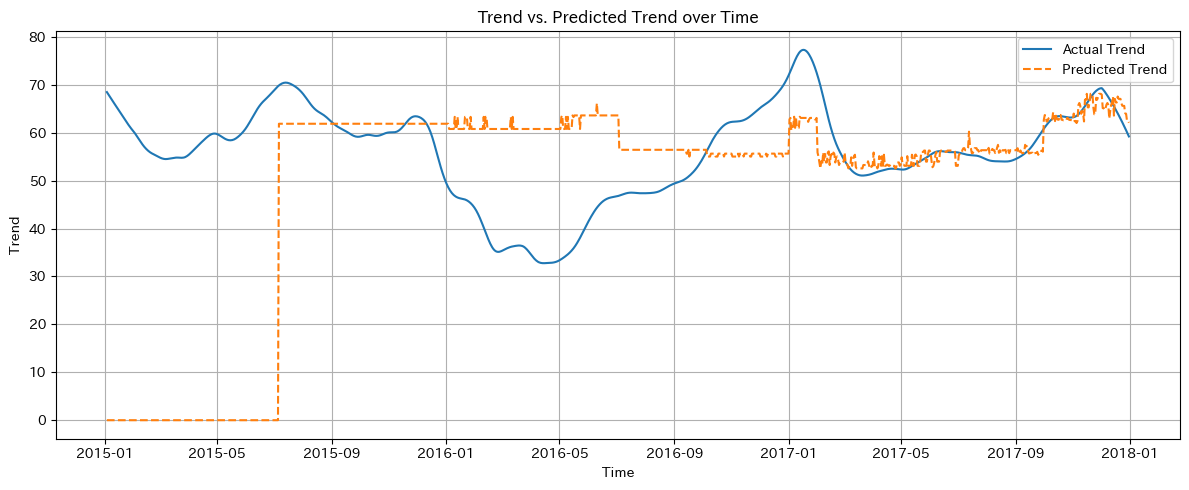

In [221]:
# プロット
plt.figure(figsize=(12, 5))
plt.plot(model1_df['time'], model1_df['trend'], label='Actual Trend')
plt.plot(model1_df['time'], model1_df['trend_pred'], label='Predicted Trend', linestyle='--')

plt.xlabel('Time')
plt.ylabel('Trend')
plt.title('Trend vs. Predicted Trend over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [20]:
model1_df['date'] = model1_df[_common.UNIQUE_KEY_COLS].dt.date

model2_df = model2_df.reset_index()
model2_df['date'] = model2_df[_common.UNIQUE_KEY_COLS].dt.date

model2_df = model2_df.merge(
    model1_df[['date', 'price_day_ahead_pred']],
    on='date',
    how='left'
)

## Seasonal

In [ ]:
# STLで得た seasonal 成分から固定パターンを作成
train_df = train_df.reset_index()
train_df['tmp_month'] = train_df[_common.UNIQUE_KEY_COLS].dt.month
train_df['tmp_weekday'] = train_df[_common.UNIQUE_KEY_COLS].dt.weekday
train_df['tmp_hour'] = train_df[_common.UNIQUE_KEY_COLS].dt.hour

# 平均seasonalパターンを計算
seasonal_table = train_df.groupby(['tmp_month', 'tmp_weekday', 'tmp_hour'])['seasonal'].mean()

# model2_df に weekday/hour を割り当てて seasonal 値を追加
model2_df['tmp_month'] = model2_df[_common.UNIQUE_KEY_COLS].dt.month
model2_df['tmp_weekday'] = model2_df[_common.UNIQUE_KEY_COLS].dt.weekday
model2_df['tmp_hour'] = model2_df[_common.UNIQUE_KEY_COLS].dt.hour

model2_df['seasonal'] = model2_df.apply(
    lambda row: seasonal_table.loc[(row['tmp_month'], row['tmp_weekday'], row['tmp_hour'])],
    axis=1
)

In [22]:
seasonal_table.reset_index().to_csv('seasonal_table.csv', index=False)

## 当日前市場（Intraday Auction）：Residual(LSTM)

#### 特徴量の整形

In [23]:
model2_df = model2_df[model2_df['price_day_ahead_pred'].notnull()]
model2_df = model2_df.drop(columns=['trend']).rename(columns={'price_day_ahead_pred': 'trend'})

In [24]:
model2_df['residual'] = model2_df[_common.TARGET_COL] - model2_df['trend'] - model2_df['seasonal']

In [25]:
model2_df[[_common.TARGET_COL, 'trend', 'seasonal', 'residual']]

,price_actual,trend,seasonal,residual
0,70.77,0.000000,-3.552164,74.322164
1,64.89,0.000000,-6.750385,71.640385
2,60.91,0.000000,-8.629045,69.539045
3,59.68,0.000000,-9.748394,69.428394
4,58.04,0.000000,-9.826383,67.866383
...,...,...,...,...
26203,39.90,68.391814,8.218433,-36.710247
26204,39.54,68.391814,9.987454,-38.839268
26205,32.90,68.391814,7.771149,-43.262964
26206,23.85,68.391814,3.158195,-47.700009


In [ ]:
fe_dynamic = [
    'total_load_actual', 'gene_sum',
    'sus_rate', 'fossil_rate', 'gene_load_ratio', 'gene_cost', 
    'residual_demand', 'residual_demand_ratio', 'w_gene_cost', 'high_cost_ratio', 
    'hour', 'weekday', 'month', 
    'gene_sum_lag1', 'gene_sum_lag24', 'gene_sum_lag48', 'gene_sum_lag72', 
    'gene_sum_rolling_mean168', 'gene_sum_rolling_mean336', 
    # 'gene_sum_rolling_mean672',
    'total_load_actual_lag1', 'total_load_actual_lag24', 'total_load_actual_lag48', 'total_load_actual_lag72',
    'total_load_actual_rolling_mean168', 'total_load_actual_rolling_mean336',
    # 'total_load_actual_rolling_mean672',
    'weighted_wind_speed','weighted_temp', 'weighted_pressure', 'weighted_humidity', 'weighted_clouds_all', 
    # 'encoded_price_weekday_hour',
    # 'valencia_weather_main_LabelEn', 'madrid_weather_main_LabelEn', 
    # 'bilbao_weather_main_LabelEn', 'barcelona_weather_main_LabelEn', 'seville_weather_main_LabelEn', 
]

fe_static = ['trend', 'seasonal']

In [92]:
# 前処理
target_col = 'residual'

# 動的特徴量のスケーリング
scaler_dynamic = MinMaxScaler()
dynamic_scaled = scaler_dynamic.fit_transform(model2_df[fe_dynamic])

# 静的特徴量のスケーリング
scaler_static = MinMaxScaler()
static_scaled = scaler_static.fit_transform(model2_df[fe_static])

# --- LSTM用の時系列ウィンドウデータ作成 ---
SEQ_LEN = 24
X_seq, X_static, y = [], [], []

for i in range(len(dynamic_scaled) - SEQ_LEN):
    X_seq.append(dynamic_scaled[i:i+SEQ_LEN])  # 時系列特徴量（24時間分）
    X_static.append(static_scaled[i+SEQ_LEN])  # 静的特徴量（当時刻の trend/seasonal）
    y.append(model2_df[target_col].iloc[i+SEQ_LEN])

X_seq = np.array(X_seq)
X_static = np.array(X_static)
y = np.array(y)

joblib.dump({
    'scaler_dynamic': scaler_dynamic,
    'scaler_static': scaler_static,
    'features_dynamic': fe_dynamic,
    'features_static': fe_static
}, 'scalers_residual_model.pkl')

['scalers_residual_model.pkl']

#### パラメータチューニング

In [95]:
def create_lstm_attention_model(input_shape_seq, input_shape_static,
                                units, num_layers, dropout, lr, l2_lambda,
                                dense_units=32):
    # --- 時系列入力 ---
    seq_input = Input(shape=input_shape_seq, name='seq_input')
    x = seq_input
    for _ in range(num_layers):
        x = LSTM(units, return_sequences=True, dropout=dropout,
                 kernel_regularizer=l2(l2_lambda))(x)

    attn_output = Attention()([x, x])  # Self-attention
    context_vector = GlobalAveragePooling1D()(attn_output)

    # --- 静的入力 ---
    static_input = Input(shape=input_shape_static, name='static_input')

    # --- 結合 ---
    concat = Concatenate()([context_vector, static_input])
    x = Dense(dense_units, activation='relu', kernel_regularizer=l2(l2_lambda))(concat)
    output = Dense(1, activation='linear', kernel_regularizer=l2(l2_lambda))(x)

    model = Model(inputs=[seq_input, static_input], outputs=output)
    model.compile(optimizer=RMSprop(learning_rate=lr), loss='mse')
    return model

def objective(trial):
    units = trial.suggest_categorical('units', [32, 64, 128])
    num_layers = trial.suggest_int('num_layers', 1, 2)
    dropout = trial.suggest_float('dropout', 0.1, 0.5)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    learning_rate = trial.suggest_float('lr', 1e-4, 1e-2)
    l2_lambda = trial.suggest_float('l2', 1e-7, 1e-3, log=True)

    tscv = TimeSeriesSplit(n_splits=3)
    rmses = []
    for train_idx, val_idx in tscv.split(X_seq):  # ← 注意: X_seq に変更
        X_train_seq, X_val_seq = X_seq[train_idx], X_seq[val_idx]
        X_train_static, X_val_static = X_static[train_idx], X_static[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        model = create_lstm_attention_model(
            input_shape_seq=(X_seq.shape[1], X_seq.shape[2]),
            input_shape_static=(X_static.shape[1],),
            units=units, num_layers=num_layers, dropout=dropout,
            lr=learning_rate, l2_lambda=l2_lambda
        )

        es = EarlyStopping(patience=20, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=8, min_lr=1e-6)

        model.fit(
            [X_train_seq, X_train_static], y_train,
            epochs=200,
            batch_size=batch_size,
            validation_data=([X_val_seq, X_val_static], y_val),
            verbose=0,
            callbacks=[es, reduce_lr]
        )

        y_pred = model.predict([X_val_seq, X_val_static]).flatten()
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        rmses.append(rmse)

    return np.mean(rmses)

# --- Optunaでパラメータ探索 ---
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=15)

print("Best params:", study.best_params)
print("Best CV RMSE:", study.best_value)

[I 2025-06-16 09:20:45,546] A new study created in memory with name: no-name-3a4aa574-26d9-442f-91f2-3abd4274f573


205/205 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


[I 2025-06-16 09:31:01,055] Trial 0 finished with value: 12.066005506383513 and parameters: {'units': 128, 'num_layers': 2, 'dropout': 0.1368960647131836, 'batch_size': 64, 'lr': 0.005714568151461423, 'l2': 0.00016847111599075526}. Best is trial 0 with value: 12.066005506383513.


205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


[I 2025-06-16 09:35:11,968] Trial 1 finished with value: 12.456993617880881 and parameters: {'units': 128, 'num_layers': 1, 'dropout': 0.2779197457042524, 'batch_size': 64, 'lr': 0.007013322661792055, 'l2': 4.91364271918909e-06}. Best is trial 0 with value: 12.066005506383513.


205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-06-16 09:39:18,132] Trial 2 finished with value: 14.656250538191381 and parameters: {'units': 64, 'num_layers': 1, 'dropout': 0.3453777333652326, 'batch_size': 16, 'lr': 0.0039494605973880905, 'l2': 2.2683606328313396e-05}. Best is trial 0 with value: 12.066005506383513.


205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


[I 2025-06-16 09:45:21,468] Trial 3 finished with value: 14.13952192181808 and parameters: {'units': 128, 'num_layers': 1, 'dropout': 0.36286782661570227, 'batch_size': 32, 'lr': 0.006793060784287345, 'l2': 2.8745302451542003e-07}. Best is trial 0 with value: 12.066005506383513.


205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


[I 2025-06-16 09:47:45,593] Trial 4 finished with value: 13.334804329995995 and parameters: {'units': 32, 'num_layers': 2, 'dropout': 0.3889718433419481, 'batch_size': 64, 'lr': 0.008167236081643285, 'l2': 2.760412630280941e-05}. Best is trial 0 with value: 12.066005506383513.


205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-06-16 09:49:01,483] Trial 5 finished with value: 12.388184475018463 and parameters: {'units': 32, 'num_layers': 1, 'dropout': 0.19016972311705854, 'batch_size': 64, 'lr': 0.004751678049715371, 'l2': 2.105154583645542e-05}. Best is trial 0 with value: 12.066005506383513.


205/205 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


[I 2025-06-16 09:58:07,783] Trial 6 finished with value: 13.608104279133384 and parameters: {'units': 128, 'num_layers': 2, 'dropout': 0.4979305657042369, 'batch_size': 64, 'lr': 0.003617158710965013, 'l2': 0.00021564546638946588}. Best is trial 0 with value: 12.066005506383513.


205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-06-16 10:20:19,258] Trial 7 finished with value: 13.190370941881483 and parameters: {'units': 32, 'num_layers': 1, 'dropout': 0.29019558427590875, 'batch_size': 16, 'lr': 0.005460471431506868, 'l2': 1.8024445226260912e-06}. Best is trial 0 with value: 12.066005506383513.


205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


[I 2025-06-16 10:23:18,165] Trial 8 finished with value: 14.409725909562498 and parameters: {'units': 64, 'num_layers': 1, 'dropout': 0.2477784723249303, 'batch_size': 32, 'lr': 0.005459756390996528, 'l2': 0.000136817921962166}. Best is trial 0 with value: 12.066005506383513.


205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-06-16 10:24:56,453] Trial 9 finished with value: 14.31280780139727 and parameters: {'units': 32, 'num_layers': 1, 'dropout': 0.3217092339486216, 'batch_size': 32, 'lr': 0.007955566613816757, 'l2': 0.0002058012252192353}. Best is trial 0 with value: 12.066005506383513.


205/205 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


[I 2025-06-16 10:36:27,729] Trial 10 finished with value: 12.142907643073992 and parameters: {'units': 128, 'num_layers': 2, 'dropout': 0.15220916748138358, 'batch_size': 64, 'lr': 0.0016582967808379456, 'l2': 0.0006842962011331222}. Best is trial 0 with value: 12.066005506383513.


205/205 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


[I 2025-06-16 10:46:06,147] Trial 11 finished with value: 12.815411549911346 and parameters: {'units': 128, 'num_layers': 2, 'dropout': 0.11055403382742744, 'batch_size': 64, 'lr': 0.000669927181955188, 'l2': 0.0009378872029529254}. Best is trial 0 with value: 12.066005506383513.


205/205 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


[I 2025-06-16 11:41:45,061] Trial 12 finished with value: 12.6642276557304 and parameters: {'units': 128, 'num_layers': 2, 'dropout': 0.10003902220030636, 'batch_size': 64, 'lr': 0.0014344628670253379, 'l2': 0.0004125145221698535}. Best is trial 0 with value: 12.066005506383513.


205/205 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


[I 2025-06-16 11:58:23,653] Trial 13 finished with value: 12.767110046476562 and parameters: {'units': 128, 'num_layers': 2, 'dropout': 0.18401424582649734, 'batch_size': 64, 'lr': 0.002408198291414985, 'l2': 8.54666570521892e-05}. Best is trial 0 with value: 12.066005506383513.


205/205 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


[I 2025-06-16 12:15:35,820] Trial 14 finished with value: 13.521569539354168 and parameters: {'units': 128, 'num_layers': 2, 'dropout': 0.16251622670712293, 'batch_size': 64, 'lr': 0.009603306088461536, 'l2': 0.0008940238007593443}. Best is trial 0 with value: 12.066005506383513.


Best params: {'units': 128, 'num_layers': 2, 'dropout': 0.1368960647131836, 'batch_size': 64, 'lr': 0.005714568151461423, 'l2': 0.00016847111599075526}
Best CV RMSE: 12.066005506383513


#### 全データで学習

In [96]:
best_params = study.best_params
units = best_params['units']
num_layers = best_params['num_layers']
dropout = best_params['dropout']
batch_size = best_params['batch_size']
learning_rate = best_params['lr']
l2_lambda = best_params['l2']

Epoch 1/100
410/410 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - loss: 545.0140 - learning_rate: 0.0057
Epoch 2/100
410/410 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - loss: 211.5410 - learning_rate: 0.0057
Epoch 3/100
410/410 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - loss: 133.5043 - learning_rate: 0.0057
Epoch 4/100
410/410 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - loss: 118.1829 - learning_rate: 0.0057
Epoch 5/100
410/410 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - loss: 112.5576 - learning_rate: 0.0057
Epoch 6/100
410/410 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - loss: 105.4396 - learning_rate: 0.0057
Epoch 7/100
410/410 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - loss: 102.1221 - learning_rate: 0.0057
Epoch 8/100
410/410 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - loss: 99.0271 - learning_rate: 0.0057
Epoch 9/100
410/410 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - loss: 97.2316 - learning_rate: 0.0057
Epoch 10/100
410/410 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - loss: 96.1846 - learning_rate: 0.0057
Epoch 11/100
410/410 ━━━━━━━━━━━━━━━━━━━━ 

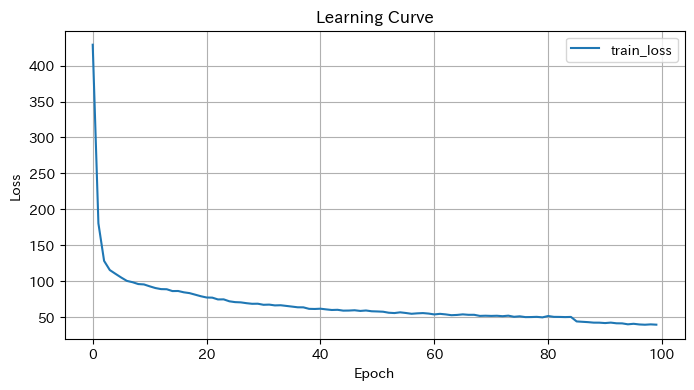

In [102]:
SEQ_LEN = 24
X_seq, X_static, y = [], [], []

for i in range(len(dynamic_scaled) - SEQ_LEN):
    X_seq.append(dynamic_scaled[i:i+SEQ_LEN])  # 時系列データ (24, d)
    X_static.append(static_scaled[i+SEQ_LEN])  # trend, seasonal（1時点分のみ）
    y.append(model2_df[target_col].iloc[i+SEQ_LEN])

X_seq = np.array(X_seq)        # shape: (n_samples, 24, d)
X_static = np.array(X_static)  # shape: (n_samples, 2)
y = np.array(y)                # shape: (n_samples,)

# --- Attention付きLSTMモデルの構築 ---
residual_model = create_lstm_attention_model(
    input_shape_seq=(SEQ_LEN, X_seq.shape[2]),
    input_shape_static=(X_static.shape[1],),
    units=units,
    num_layers=num_layers,
    dropout=dropout,
    lr=learning_rate,
    l2_lambda=l2_lambda
)

# --- コールバックの設定 ---
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=1e-6)

# --- 学習 ---
history = residual_model.fit(
    [X_seq, X_static], y,
    epochs=100,
    batch_size=batch_size,
    verbose=1,
    callbacks=[reduce_lr]
)

# --- 全データでの予測とRMSE計算 ---
y_pred = residual_model.predict([X_seq, X_static]).flatten()
rmse = np.sqrt(mean_squared_error(y, y_pred))
print(f"Train RMSE: {rmse:.3f}")

# --- 学習曲線の可視化 ---
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='train_loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.grid(True)
plt.show()

In [103]:
residual_model.save('../output/モデル/residual_model.keras')

#### OOF予測を作成

In [137]:
def lstm_oof_predictions_with_best_params(
    X_seq, X_static, y,
    trend_pred, seasonal_pred,  # ← trend / seasonal を個別で受け取る
    model2_df,
    best_params,
    n_splits=3
):
    oof_preds_resid = np.full(len(y), np.nan)
    tscv = TimeSeriesSplit(n_splits=n_splits)

    for fold, (train_idx, val_idx) in enumerate(tscv.split(X_seq)):
        print(f'Fold {fold + 1}/{n_splits}')
        
        X_train_seq, X_val_seq = X_seq[train_idx], X_seq[val_idx]
        X_train_static, X_val_static = X_static[train_idx], X_static[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        model = create_lstm_attention_model(
            input_shape_seq=(X_seq.shape[1], X_seq.shape[2]),
            input_shape_static=(X_static.shape[1],),
            units=best_params['units'],
            num_layers=best_params['num_layers'],
            dropout=best_params['dropout'],
            lr=best_params['lr'],
            l2_lambda=best_params['l2']
        )

        model.fit(
            [X_train_seq, X_train_static], y_train,
            epochs=200,
            batch_size=best_params['batch_size'],
            validation_data=([X_val_seq, X_val_static], y_val),
            verbose=0,
            callbacks=[
                tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True),
                tf.keras.callbacks.ReduceLROnPlateau(patience=10)
            ]
        )

        preds = model.predict([X_val_seq, X_val_static]).flatten()
        oof_preds_resid[val_idx] = preds

    # --- Residualの正解値 ---
    actual_resid = model2_df['residual'].values[:len(oof_preds_resid)]

    # --- Residual RMSE（目的：この精度だけを見たい）---
    resid_rmse = np.sqrt(mean_squared_error(actual_resid[~np.isnan(oof_preds_resid)],
                                            oof_preds_resid[~np.isnan(oof_preds_resid)]))
    print(f'ResidualのOOF RMSE: {resid_rmse:.4f}')

    # --- trend + seasonal + residual = intraday price（合成も一応残す）---
    trend_pred = trend_pred[:len(oof_preds_resid)]
    seasonal_pred = seasonal_pred[:len(oof_preds_resid)]
    final_pred = trend_pred + seasonal_pred + oof_preds_resid
    model2_df.loc[:len(final_pred)-1, 'intraday_price'] = final_pred

    return final_pred, oof_preds_resid, resid_rmse

In [139]:
SEQ_LEN = 24
model3_df = model2_df.iloc[SEQ_LEN:].reset_index(drop=True)

# --- 置き換えた関数の呼び出し ---
final_pred, oof_resid, residual_rmse = lstm_oof_predictions_with_best_params(
    X_seq=X_seq,
    X_static=X_static,
    y=y,
    trend_pred=model3_df['trend'].values,
    seasonal_pred=model3_df['seasonal'].values,
    model2_df=model3_df,
    best_params=best_params,
    n_splits=3
)

Fold 1/3
205/205 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Fold 2/3
205/205 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Fold 3/3
205/205 ━━━━━━━━━━━━━━━━━━━━ 31s 149ms/step
ResidualのOOF RMSE: 13.4680


## 当日前市場（Continuous Auction）

In [140]:
model3_df['continuous_price'] = model3_df[_common.TARGET_COL] - model3_df['trend'] - model3_df['seasonal'] - model3_df['intraday_price']

In [156]:
model3_df[[_common.TARGET_COL, 'trend', 'seasonal', 'intraday_price', 'continuous_price']]

,price_actual,trend,seasonal,intraday_price,continuous_price
6546,58.42,59.634182,5.042943,64.659660,-70.916785
6547,64.70,59.634182,8.180917,68.477915,-71.593015
6548,62.16,59.634182,9.690337,70.070818,-77.235337
6549,51.41,59.634182,7.018218,67.281417,-82.523817
6550,47.31,59.634182,2.129101,62.293587,-76.746870
...,...,...,...,...,...
26179,39.90,68.391814,8.218433,70.901889,-107.612137
26180,39.54,68.391814,9.987454,72.726547,-111.565815
26181,32.90,68.391814,7.771149,69.899250,-113.162213
26182,23.85,68.391814,3.158195,65.028290,-112.728299


In [147]:
model3_df = model3_df[model3_df['intraday_price'].notnull()]

In [148]:
fe_model3 = [
    'total_load_actual', 'gene_sum',
    'sus_rate', 'fossil_rate', 'gene_load_ratio', 'gene_cost',
    'residual_demand', 'residual_demand_ratio', 'w_gene_cost', 'high_cost_ratio', 
    'hour', 'weekday', 'month', 
    'gene_sum_lag1', 'gene_sum_lag24',
    'total_load_actual_lag1', 'total_load_actual_lag24',
    'weighted_wind_speed', 'weighted_temp', 'weighted_pressure', 'weighted_humidity', 'weighted_clouds_all',
    'valencia_weather_main_LabelEn', 'madrid_weather_main_LabelEn',
    'bilbao_weather_main_LabelEn', 'barcelona_weather_main_LabelEn', 'seville_weather_main_LabelEn',
    'seasonal', 'trend', 'intraday_price'
]

In [149]:
X_train = model3_df[fe_model3]
y_train = model3_df['continuous_price']

In [ ]:
default_params = {
    'objective': 'reg:squantileerror',
    'eval_metric': 'rmse',
    'verbosity': 0,
    'seed': 1234
}

tscv = TimeSeriesSplit(n_splits=5)

#### パラメータチューニング

In [151]:
# 最適化の対象関数
def objective(trial):
    return func.run_optuna(
        trial=trial,
        features=X_train,         # 特徴量データフレーム
        target=y_train,           # 目的変数
        cv_strategy=tscv,         # ← partition_col → cv_strategy に変更済み
        model_name='xgb',
        default_columns=default_params,
        metric='rmse',
        random_seed=SEED
    )

# Optuna スタディの作成・実行
study = optuna.create_study(
    direction='minimize',
    sampler=optuna.samplers.TPESampler(seed=SEED)
)
study.optimize(objective, n_trials=50, timeout=1800)

# 最良トライアルの結果
trial = study.best_trial
xgb_params = default_params | trial.params  # Python 3.9以降

# 結果の表示
print('Best trial:')
print(f'RMSE: {trial.value:.4f}')
print('Params:')
for key, value in trial.params.items():
    print(f'{key}: {value}')

[I 2025-06-16 15:31:30,574] A new study created in memory with name: no-name-0f535c8f-dfd4-41b5-b859-d7baeeec3938

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
The reported value is ignored because this `step` 0 is already reported.
The reported value is ignored because this `step` 1 is already reported.
The reported value is ignored because this `step` 2 is already reported.
The reported value is ignored because this `step` 3 is already reported.
The reported value is ignored because this `step` 4 is already reported.
The reported value is ignored because this `step` 5 is already reported.
The reported value is ignored because this `step` 6 is already reported.
The reported value is ignored because this `step` 7 is already reported.
The reported value is ignored because 

Best trial:
RMSE: 12.0504
Params:
learning_rate: 0.05497595077699531
max_depth: 5
subsample: 0.9318479864837121
colsample_bytree: 0.964792357190835
gamma: 0.18244299195068614
min_child_weight: 1.307698089216747
lambda: 0.037690620821488274
alpha: 0.18441200300098726


#### 全データで学習

In [152]:
import xgboost as xgb

# DMatrix の作成
dtrain = xgb.DMatrix(X_train, label=y_train)

best_iteration = trial.user_attrs.get('best_iteration')

# モデルの再学習
final_model = xgb.train(
    xgb_params,          # 最適化後のパラメータ
    dtrain,
    num_boost_round=best_iteration,
    evals=[(dtrain, 'train')],
    verbose_eval=False
)

# トレーニングデータで予測
y_train_pred = final_model.predict(dtrain)

# RMSEを計算
final_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
print(f"XGBoostのトレーニングRMSE: {final_rmse:.4f}")

XGBoostのトレーニングRMSE: 3.1319


In [153]:
# 保存用のディクショナリにまとめる
model_package = {
    'model': final_model,
    'feature_name': X_train.columns.tolist()
}

# 保存
with open('../output/モデル/continuous_price_model.pkl', 'wb') as f:
    pickle.dump(model_package, f)